1. Industry performance across regimes
1. Industry average weight across regimes (need results for this)
1. Regimes probabilities across time
1. Performance of the three factors across regimes

In [1]:
import pandas as pd
from regimeaware.routines import cfg
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from regimeaware.routines import cfg
import numpy as np
from sklearn import preprocessing
from hmmlearn.hmm import GaussianHMM
from matplotlib.ticker import StrMethodFormatter
import pandas_datareader as pdr
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from scipy import interpolate
from scipy.stats import norm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

dpi = 300
width = 7.5
height = 4.5

In [2]:
# rec_flag = pdr.get_data_fred('USREC', start='1960', end='2022-12').squeeze()
# rec_flag.index = rec_flag.index + pd.tseries.offsets.MonthEnd()
emission_prob = pd.read_pickle(f"{cfg.data_fldr}/regimes/emission_prob.pkl")
transition_matrix = pd.read_pickle(f"{cfg.data_fldr}/regimes/transmat.pkl")
mu_f = pd.read_pickle(f"{cfg.data_fldr}/regimes/mu.pkl")
sigma_f = pd.read_pickle(f"{cfg.data_fldr}/regimes/sigma.pkl")
ff_raw = pd.read_pickle(f'{cfg.data_fldr}/ff_daily.pkl').sort_index()[cfg.factor_set + ['umd']]
weekly_dts = pd.date_range(start=ff_raw.index[0], end=ff_raw.index[-1], freq=cfg.data_freq)
ff = ff_raw.loc[weekly_dts[0]:weekly_dts[-1]].add(1).groupby(pd.Grouper(freq=cfg.data_freq)).prod().sub(1)
mktcap = pd.read_pickle(f'{cfg.data_fldr}/mktcap.pkl')
is_tradable = pd.read_pickle(f'{cfg.data_fldr}/is_tradable.pkl')
sector = pd.read_pickle(f'{cfg.data_fldr}/gics_mapping.pkl')['sector']

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Excess returns
rt = pd.read_pickle(f'{cfg.data_fldr}/crsp_daily.pkl')[['ret']]
rt = pd.pivot_table(rt, index='date', columns='permno', values='ret')
first_obs_dt = rt.apply(pd.Series.first_valid_index)
last_obs_dt = rt.apply(pd.Series.last_valid_index)
last_obs_dt.replace({pd.to_datetime('2022-12-30'): pd.to_datetime('2022-12-31')}, inplace=True)  # Patch to avoid losing the last obs
rt = rt.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)
for sec_id in rt.columns:
    rt[sec_id] = rt.loc[first_obs_dt[sec_id]:last_obs_dt[sec_id], sec_id]

ff = pd.read_pickle(f'{cfg.data_fldr}/ff_daily.pkl').sort_index()
ff = ff.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)
rf = ff['rf']
rt = rt.sub(rf, axis=0).dropna(how='all')

C:\Users\franc\AppData\Local\Temp\ipykernel_20344\1833042094.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rt = rt.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)
C:\Users\franc\AppData\Local\Temp\ipykernel_20344\1833042094.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff = ff.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)


## Determining the number of states

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

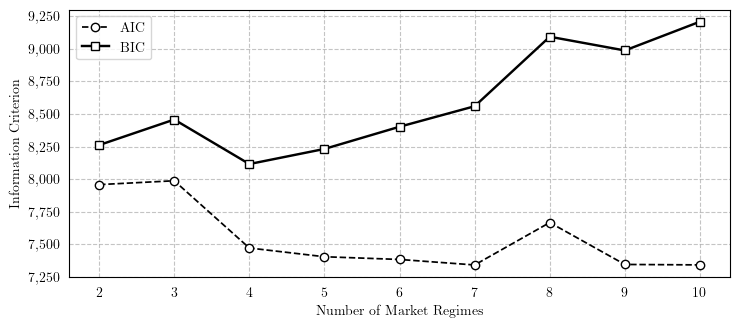

In [3]:
states_to_try = range(2, 11)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
trn_raw = ff.loc[cfg.trn_start_dt:cfg.bt_start_dt]
scaler = preprocessing.StandardScaler(copy=True).fit(trn_raw)
trn_std = scaler.transform(trn_raw)

for n in states_to_try:    
    mdl = GaussianHMM(
        n_components=n,
        covariance_type="full",
        random_state=0,
    )
    mdl.fit(trn_std)
    bic[n] = mdl.bic(trn_std)
    aic[n] = mdl.aic(trn_std)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, height * .75), sharex=True, sharey=False)
plot_map = {'AIC': (aic, '--', 1.25, 'o'), 'BIC': (bic, '-', 1.75, 's')}

for label, params in plot_map.items():
    ax.plot(params[0], color='k', marker=params[3], mfc='white', lw=params[2], ls=params[1])
    ax.grid(ls='--', alpha=.75)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['AIC', 'BIC'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/state_calibration.pdf", dpi=dpi, transparent=True)
plt.show()


## Market regimes smoothed probabilities

In [4]:
state_order = [2, 0, 3, 1]
regime_map = {
    2: "Market Regime 1",
    0: "Market Regime 2",
    3: "Market Regime 3",
    1: "Market Regime 4",
}

C:\Users\franc\AppData\Local\Temp\ipykernel_20344\1045815513.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = data[i].resample('M').mean()


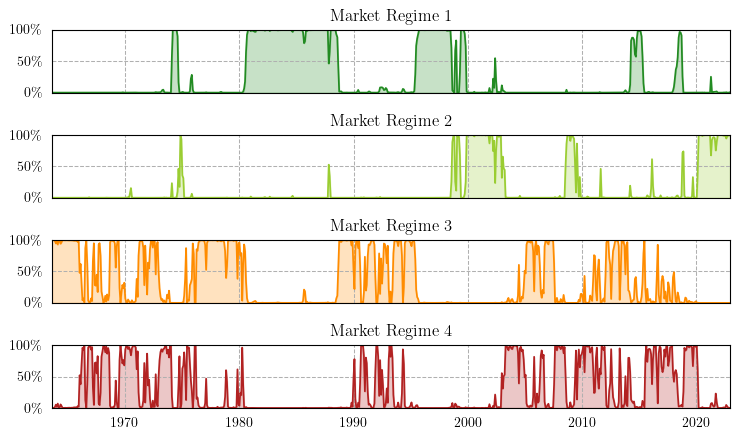

In [5]:
cmap = ['forestgreen', 'yellowgreen', 'darkorange', 'firebrick']
# cmap = mpl.colormaps['RdYlGn_r'].resampled(4)
# cmap = [cmap(x) for x in range(4)]
fig, axs = plt.subplots(nrows=emission_prob.shape[1], figsize=(width, height), sharex=True)
data = emission_prob.xs(emission_prob.index.get_level_values('as_of')[-1])
data[state_order]
for i, ax in enumerate(axs):
    ts = data[i].resample('M').mean()
    ax.plot(ts, color=cmap[i], lw=1.25)
    ax.fill_between(ts.index, ts, color=cmap[i], alpha=.25)
    ax.set_title(f'Market Regime {i + 1}')
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_yticks([0, .5, 1])
    ax.grid(ls='--', lw=.75)
    ax.set_ylim(0, 1)
    ax.set_xlim(ts.index[0], ts.index[-1])


plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/emission_prob.pdf", dpi=dpi, transparent=True)
plt.show()

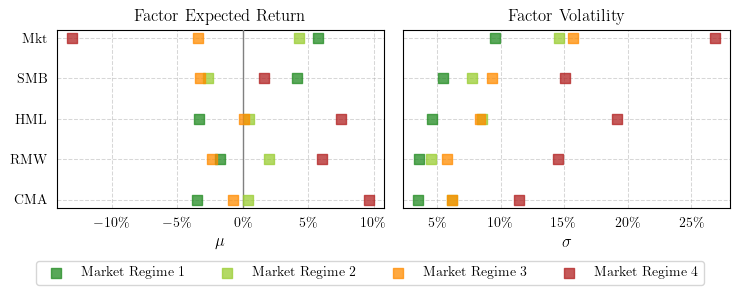

In [6]:
X = mu_f.xs(mu_f.index.get_level_values('as_of')[-1]).mul(52).T
X = X[state_order]
X.index.name = 'factor'
X.rename(regime_map, axis=1, inplace=True)

S = sigma_f.xs(sigma_f.index.get_level_values('as_of')[-1])
S = pd.DataFrame.from_dict({x: pd.Series(np.diag(S.xs(x)), index=sigma_f.columns) for x in range(4)})
S = S.mul(52).apply(np.sqrt)
S = S[state_order]
S.index.name = 'factor'
S.columns.name = 'state'
S.rename(regime_map, axis=1, inplace=True)


factor_labels = {
    'mktrf': 'Mkt',
    'smb': 'SMB', 
    'hml': 'HML', 
    'rmw': 'RMW', 
    'cma': 'CMA'
}
sorting_y = ['cma', 'rmw', 'hml', 'smb', 'mktrf']

fig, axs = plt.subplots(ncols=2, figsize=(width, height * .6), sharex=False, sharey=True)
for i, col in enumerate(X.columns):
    axs[0].scatter(y=range(X.shape[0]), x=X.loc[sorting_y, col].values, color=cmap[i], zorder=25, s=60, marker='s', alpha=.75)
    axs[1].scatter(y=range(X.shape[0]), x=S.loc[sorting_y, col].values, color=cmap[i], zorder=25, s=60, marker='s', alpha=.75)


for ax in axs:
    ax.set_yticks(range(5))
    ax.set_yticklabels([factor_labels[x] for x in sorting_y])
    ax.grid(ls='--', zorder=-25, lw=.75, alpha=.5)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.tick_params(axis='both', bottom=False, left=False)

axs[0].set_title('Factor Expected Return')
axs[1].set_title('Factor Volatility')
axs[0].set_xlabel('$\mu$', fontsize=12)
axs[1].set_xlabel('$\sigma$', fontsize=12)

lgd = fig.legend([f'Market Regime {x + 1}' for x in range(4)], ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.1))
axs[0].axvline(0, c='gray', lw=1, zorder=10)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/mu_sigma_factors.pdf", dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

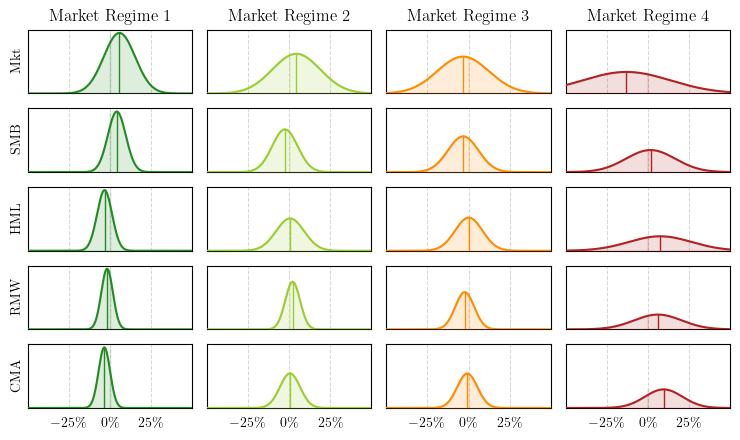

In [7]:
X_long = X.melt(ignore_index=False).reset_index().set_index(['factor', 'state']).sort_index().loc[cfg.factor_set].squeeze()
S_long = S.melt(ignore_index=False).reset_index().set_index(['factor', 'state']).sort_index().loc[cfg.factor_set].squeeze()

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(width, height), sharex=True, sharey='row')
x_axis = np.arange(-1, 1, 0.001)
cmap_dict = dict(zip(S.columns, cmap))

for labels, ax in zip(S_long.index, axs.flatten()):
    dist_vals = norm.pdf(x_axis, X.loc[labels], S.loc[labels])
    dist_vals = dist_vals / sum(dist_vals)
    ax.plot(x_axis, dist_vals, color=cmap_dict[labels[1]], zorder=25)
    ax.fill_betweenx(dist_vals, x_axis, color=cmap_dict[labels[1]], alpha=.15, zorder=20)
    ax.set_ylim((0, ax.get_ylim()[1]))
    ax.grid(ls='--', zorder=-25, lw=.75, alpha=.5)
    ax.axvline(x=X.loc[labels], ymin=0, ymax=max(dist_vals) / ax.get_ylim()[1], zorder=10, color=cmap_dict[labels[1]], lw=1, ls='-')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.set_xlim(-.5, .5)
    ax.set_xticks([-.25, 0, .25])
    ax.set_yticks([])

for i, state in enumerate(X.columns):
    axs[0, i].set_title(state)

for i, factor in enumerate(cfg.factor_set):
    axs[i, 0].set_ylabel(factor_labels[factor])

plt.tight_layout()
# fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{cfg.fldr}/img/state_dist_factors.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

## Sectors vs. Recessions

In [8]:
rt_long = rt.melt(ignore_index=False).reset_index().set_index(['date', 'permno']).squeeze().dropna().sort_index()

obs_dates = rt_long.index.get_level_values('date').unique()
mcap_dates = mktcap.index.get_level_values('date').unique()
dt_mapping = {mcap_dates.asof(x): x for x in obs_dates}
mktcap_mnth = mktcap.loc[dt_mapping.keys()]

sector_size = mktcap_mnth.to_frame('sector_size').join(sector).groupby(['date', 'sector']).sum()
df_mcap = mktcap_mnth.to_frame('market_cap').join(sector).dropna()
df_mcap = df_mcap.join(sector_size, on=['date', 'sector'])
sector_wts = df_mcap['market_cap'].div(df_mcap['sector_size'])
sector_wts_flat = pd.pivot_table(sector_wts.to_frame('weight').join(sector), index=['date', 'permno'], values='weight', columns='sector')
sector_rt = sector_wts_flat.groupby(['permno']).shift(1).mul(rt_long, axis=0).dropna(how='all').groupby('date').sum()

In [9]:
bt_wts = pd.read_pickle(f'{cfg.data_fldr}/results/sector_trackingerror_wts.pkl')
bt_wts.rename({x: round(x, 3) for x in bt_wts.index.get_level_values('tev').unique()}, inplace=True)
rt_ext = rt.reindex(bt_wts.index.get_level_values('date'))[bt_wts.columns]
rt_ext.index = bt_wts.index
bt_rt = bt_wts.groupby('tev').shift(1).mul(rt_ext).sum(axis=1)
rebalance_dates = factor_loadings.index.get_level_values('date').unique()
crsp_dates = mktcap.index.get_level_values('date').unique()
mktcap_eom = mktcap_mnth.rename({crsp_dates.asof(x): x for x in rebalance_dates})
total_mktcap = mktcap_eom.reindex(is_tradable.index).groupby('date').sum()
mktcap_wts = mktcap_eom.div(total_mktcap)
bm_rt = mktcap_wts.groupby('permno').shift(1).mul(rt_long).dropna().groupby('date').sum()
bt_rt_flat = pd.pivot_table(bt_rt.to_frame('rt'), index='date', columns='tev', values='rt')
rt_flat = bt_rt_flat.join(bm_rt.rename('vw')).dropna()
tracking = rt_flat.sub(rt_flat['vw'], axis=0).drop('vw', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = rt_flat.mean().div(rt_flat.std()).mul(np.sqrt(12))

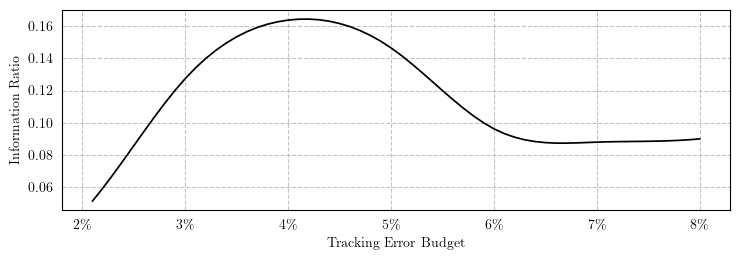

In [10]:
raw = ir[[.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]].copy()
x = list(raw.index)
y = raw.astype(float).values
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.arange(.01, .10, .001)
ir_smoothed = pd.Series(f(x_new), index=x_new)

fig, ax = plt.subplots(figsize=(width, height * .6))
ax.plot(ir_smoothed[.02:.08], color='black', lw=1.25, zorder=25)
ax.grid(ls='--', alpha=.75, zorder=-25)
ax.set_xlabel('Tracking Error Budget')
ax.set_ylabel('Information Ratio')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.tick_params(axis='both', bottom=False, left=False)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/ir_tev.pdf", dpi=dpi, transparent=True)
plt.show()

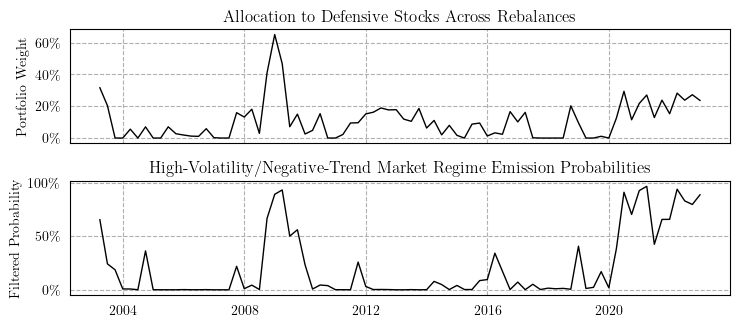

In [11]:
# MSCI classification
defensive_names = ['Utilities', 'Consumer Staples', 'Health Care', 'Energy']
cyclical_names = ['Materials', 'Consumer Discretionary', 'Financials', 'Real Estate', 'Communication Services', 'Information Technology', 'Industrials']

defensive_ids = sector[sector.isin(defensive_names)].index
cyclical_ids = sector[sector.isin(cyclical_names)].index

tev = .04

wts_defensive = bt_wts.xs(tev).loc[:, bt_wts.columns.isin(defensive_ids)].sum(axis=1)
wts_cyclical = bt_wts.xs(tev).loc[:, bt_wts.columns.isin(cyclical_ids)].sum(axis=1)

wts_rotation = pd.concat([wts_cyclical, (1 - wts_cyclical - wts_defensive).round(4), wts_defensive], axis=1)
wts_rotation.columns = ['Cyclical', 'Neutral', 'Defensive']

bear_state_sel = pd.pivot_table(mu_f['mktrf'].to_frame(), index='as_of', columns='state', values='mktrf').idxmin(axis=1)
idx = pd.MultiIndex.from_tuples(bear_state_sel.items(), names=['as_of', 'state'])

filtered_prob = emission_prob.groupby('as_of').last()
filtered_prob = filtered_prob.melt(var_name='state', ignore_index=False).reset_index().set_index(['as_of', 'state']).sort_index().squeeze()
bear_filtered_prob = filtered_prob.reindex(idx).droplevel('state')

fig, axs = plt.subplots(nrows=2, figsize=(width, height * .75), sharex=True, sharey=False)
axs[0].plot(wts_rotation['Defensive']['2003':].resample('QE').mean(), color='black', lw=1)
axs[0].grid(ls='--')
axs[1].grid(ls='--')
axs[1].plot(bear_filtered_prob['2003':].resample('QE').mean(), color='black', lw=1)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].tick_params(axis='both', bottom=False, left=False)
axs[0].set_ylabel("Portfolio Weight")
axs[1].set_ylabel("Filtered Probability")
axs[1].tick_params(axis='both', bottom=False, left=False)
axs[0].set_title('Allocation to Defensive Stocks Across Rebalances')
axs[1].set_title('High-Volatility/Negative-Trend Market Regime Emission Probabilities')

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/defensive_allocation.pdf", dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

In [12]:
bt_wts = pd.read_pickle(f'{cfg.data_fldr}/results/sn_riskaversion_wts.pkl')
bt_wts.rename({x: round(x, 3) for x in bt_wts.index.get_level_values('gamma').unique()}, inplace=True)
rt_ext = rt.reindex(bt_wts.index.get_level_values('date'))[bt_wts.columns]
rt_ext.index = bt_wts.index
bt_rt = bt_wts.groupby('gamma').shift(1).mul(rt_ext).sum(axis=1)
rebalance_dates = factor_loadings.index.get_level_values('date').unique()
crsp_dates = mktcap.index.get_level_values('date').unique()
mktcap_eom = mktcap_mnth.rename({crsp_dates.asof(x): x for x in rebalance_dates})
total_mktcap = mktcap_eom.reindex(is_tradable.index).groupby('date').sum()
mktcap_wts = mktcap_eom.div(total_mktcap)
bm_rt = mktcap_wts.groupby('permno').shift(1).mul(rt_long).dropna().groupby('date').sum()
bt_rt_flat = pd.pivot_table(bt_rt.to_frame('rt'), index='date', columns='gamma', values='rt')
rt_flat = bt_rt_flat.join(bm_rt.rename('vw')).dropna()
tracking = rt_flat.sub(rt_flat['vw'], axis=0).drop('vw', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = rt_flat.mean().div(rt_flat.std()).mul(np.sqrt(12))

In [13]:
total_n = factor_loadings.groupby(['date', 'id']).sum().groupby('date').count()
w = bt_wts.copy()
w[np.isclose(w, 0)] = np.nan
pct_invested = w.count(axis=1).div(total_n).groupby('gamma').mean()

0.6237899754209532


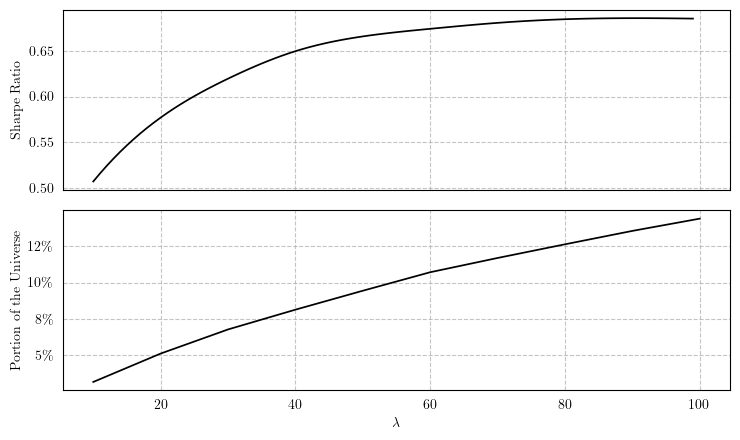

In [14]:

# raw = ir[[.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]].copy()
raw = sr.drop('vw').copy()
# raw = raw[raw.index <= 50]
print(sr['vw'])
x = list(raw.index)
y = raw.astype(float).values
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.arange(raw.index.min(), raw.index.max(), 1)
sr_smoothed = pd.Series(f(x_new), index=x_new)

fig, axs = plt.subplots(figsize=(width, height), nrows=2, sharex=True)
axs[0].plot(sr_smoothed, color='black', lw=1.25, zorder=25)
axs[0].grid(ls='--', alpha=.75, zorder=-25)
axs[1].set_xlabel('$\lambda$')
axs[0].set_ylabel('Sharpe Ratio')
axs[0].tick_params(axis='both', bottom=False, left=False)

axs[1].plot(pct_invested, color='black', lw=1.25, zorder=25)
axs[1].grid(ls='--', alpha=.75, zorder=-25)
axs[1].set_ylabel('Portion of the Universe')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].tick_params(axis='both', bottom=False, left=False)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/sr_mvo.pdf", dpi=dpi, transparent=True)
plt.show()

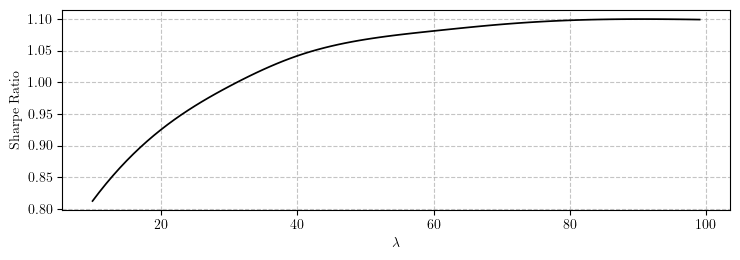

In [15]:

# raw = ir[[.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]].copy()
raw = sr.div(sr['vw']).drop('vw').copy()
x = list(raw.index)
y = raw.astype(float).values
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.arange(10, 100, 1)
sr_smoothed = pd.Series(f(x_new), index=x_new)

fig, ax = plt.subplots(figsize=(width, height * .6))
ax.plot(sr_smoothed, color='black', lw=1.25, zorder=25)
# ax.axhline(sr['vw'], color='black', lw=1.25, zorder=25)
ax.grid(ls='--', alpha=.75, zorder=-25)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Sharpe Ratio')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/sr_mvo.pdf", dpi=dpi, transparent=True)
plt.show()